# tasks
## identify the green light, find its center position (its coordinate in image)
1. problem: interference of other green stuffs?
2. task: generate fake (mock) images containing a green dot in various positions.
    answer: the shape of the images take by camera is (-------)

## obtain the parameters of the camera
1. intrinsic parameters?
    answer: the intrinsic matrix of our camera is (-------)

## transform the green light's image coordinate to the angle (yaw, etc.) relative to the camera
1. two DOF may be enough: angle x, angle y.
2. problem: how to use intrinsic param of the camera and the coordinate relative to image center to obtain the angle?

## write a ROS py program to publish the angle.

relative position to center:  (1024, 1280)
distortion coefficient: 
 [[ 0.409048 -5.01651  -0.034837 -0.036515  0.      ]]
intrinsic matrix: 
 [[1.04294267e+04 0.00000000e+00 6.39500000e+02]
 [0.00000000e+00 1.04050104e+04 5.11500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
position relative to center before un-distortion: [1024. 1280.]
position of circle center after un-distortion: [0.0373188  0.07449666]
angle relative to camera center:  (np.float32(0.03730149), np.float32(0.07435931))


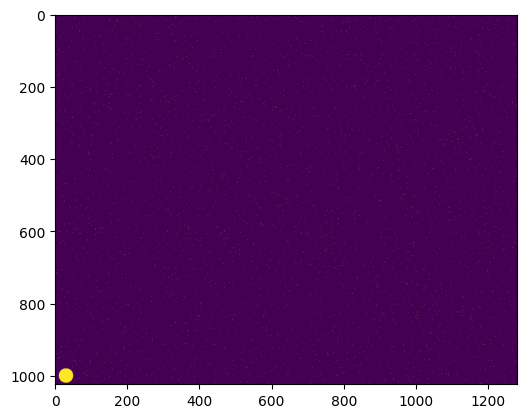

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import yaml
'''
Green Light Position Determination
A class to determine the relative position between camera and green light
'''
class GLPosition():

    '''
    image_widht and image_height is the width and height of images
    taken by our camera.
    The width and height will be used to determine the relative angle between camera and green light.
    camera_param_path is the path to yaml file containing camera intrinsic matrix and distortion coefficient
    '''
    def __init__(self, image_width=1280, image_height=1024, camera_param_path = "camparam.yaml", lower_color = [240, 240, 0], upper_color = [255, 255, 150]):
        self.image_width = image_width
        self.image_height = image_height
        self.get_camera_intrinsic_distortion(camera_param_path)
        self.lower_color = np.array(lower_color)
        self.upper_color = np.array(upper_color)

    '''
    task: load camera intrinsic from a yaml file
    '''
    def get_camera_intrinsic_distortion(self, yaml_file_name):
        with open(yaml_file_name, 'r') as file:
            contents = yaml.safe_load(file)
    
        self.IM = np.matrix(contents["intrinsic_matrix"])
        self.distort = np.matrix(contents["distortion_coefficient"])

    '''
    Task: given the image that contains a green dot
    report its center coordinate in the image
    input: image
    output, tuple (x, y). x and y can be float
    '''
    def find_green_light(self, image):
        mask = cv.inRange(image, self.lower_color, self.upper_color)
        plt.imshow(mask)
        #plt.show()
        #return
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        if contours: 
            largest_contour = max(contours, key=cv.contourArea)
            M = cv.moments(largest_contour)
            if M["m00"] !=0:
                cx = M["m10"]/M["m00"]
                cy = M["m01"]/M["m00"]
                center = (cx, cy)
            else:
                center = (-1, -1)
        return center
    '''
    Task: given a position in the image
    return its position (coordinate) relative to center
    input: pos = [x_coordinate, y_coordinate]
    output: tuple (x, y). x and y can be float
    '''
    def pos_relative_to_center(self, pos):
        relative_x = pos[0] - self.image_width/2
        relative_y = pos[1] - self.image_height/2
        return (relative_x, relative_y)

    '''
    Task: given a pixel position to image center
    calculate the angle differnence between camera direction and green light
    input: relative position of light to camera, 2-tuple (x_dev_from_center, y_dev_from_center)
    output: relative position of light to camera, 2-tuple (x_angle_from_center, y_angle_from_center)
    '''
    def get_GL_angle_relative(self, pixel_pos):
        # first, prepare the pixel coordinate
        x, y = pixel_pos
        x, y = 639, 511
        pts = np.array([[[1024, 1280]]], dtype=np.float32)

        print("position relative to center before un-distortion:", pts[0][0])
        # then, undistort and normalize coordinates
        undistorted_pts = cv.undistortPoints(pts, self.IM, self.distort)
        print("position of circle center after un-distortion:", undistorted_pts[0][0])
        x_norm, y_norm = undistorted_pts[0][0]

        # finally, get the tangent value of each side
        angle_x = np.arctan2(x_norm, 1)
        angle_y = np.arctan2(y_norm, 1)

        return (angle_x, angle_y)




image = cv.imread("img_dir/0.png")
glp = GLPosition()
pos = glp.find_green_light(image)
#rel_pos = glp.pos_relative_to_center(pos)
pos = (1024, 1280)
print("relative position to center: ", pos)
glp.get_camera_intrinsic_distortion("camparam.yaml")
print("distortion coefficient: \n", glp.distort)
print("intrinsic matrix: \n", glp.IM)
print("angle relative to camera center: ", glp.get_GL_angle_relative(rel_pos))

question: what are: center of image in IM?

In [10]:
# task: find out the shape of images (1024, 1280)
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
img = cv.imread("13.jpg")
print(img.shape)



(1024, 1280, 3)


In [22]:
# task: generate some mock images that contains green dots [250-255, 250-255, 0-150]
import numpy as np
import cv2

# Image dimensions
width, height = 1280, 1024
center_positions = []
for x in range(30, 1030, 300):
    for y in range (1000, 30, -300):
        center_positions.append([x, y])

print(center_positions)

for i, (x, y) in enumerate(center_positions):
    # 1. Generate a random RGB image (values between 0-255)
    random_image = np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)

    # Circle parameters
    center_position = (x, y)  # (x, y) - OpenCV uses (column, row)
    radius = 20
    circle_color = (253, 252, 87)  # Red in BGR (OpenCV uses BGR instead of RGB)

    # Draw the circle
    cv2.circle(random_image, center_position, radius, circle_color, -1)  # -1 for filled circle

    # Save or show the image
    cv2.imwrite(f"img_dir/{i}.png", random_image)
    #plt.imshow(random_image)
    

[[30, 1000], [30, 700], [30, 400], [30, 100], [330, 1000], [330, 700], [330, 400], [330, 100], [630, 1000], [630, 700], [630, 400], [630, 100], [930, 1000], [930, 700], [930, 400], [930, 100]]


## task: 
1. go to innowing and plug in NUC & camera. 
2. install ros2 camera calibration
3. modify camera driver to allow publishing of images
4. calibrate camera, record the result